## Example Linear Model in Python<br>
<br>

**0) Loading Libraries**<br>
<br>

In [1]:
#standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for QQ plot
import pylab 
import scipy.stats as stats

#OLS: (ordinary least squares), the function for running the linear regression
#sm: statsmodels for determining p-values via ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

#for sclaing and normalizing the data
from sklearn.preprocessing import MinMaxScaler

<br>

**1) Loading and Extracting the Data**<br>
<br>

The molecule data set contains the column *"toxicity_score"* as dependent, numerical (not categorical) variable.

In [2]:
Train  = pd.read_csv("molecular_train_gbc.csv")
Test   = pd.read_csv("molecular_test_gbc.csv")

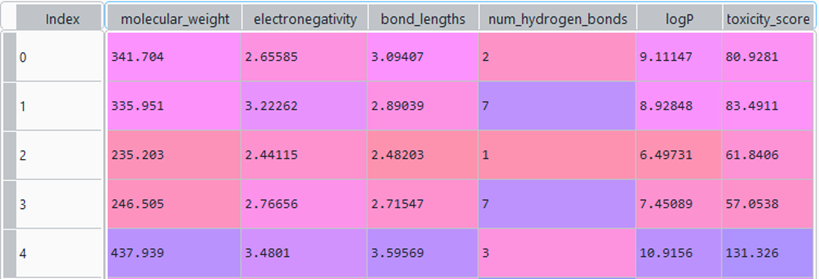

<br>

**2) Plotting the Data**<br>
<br>

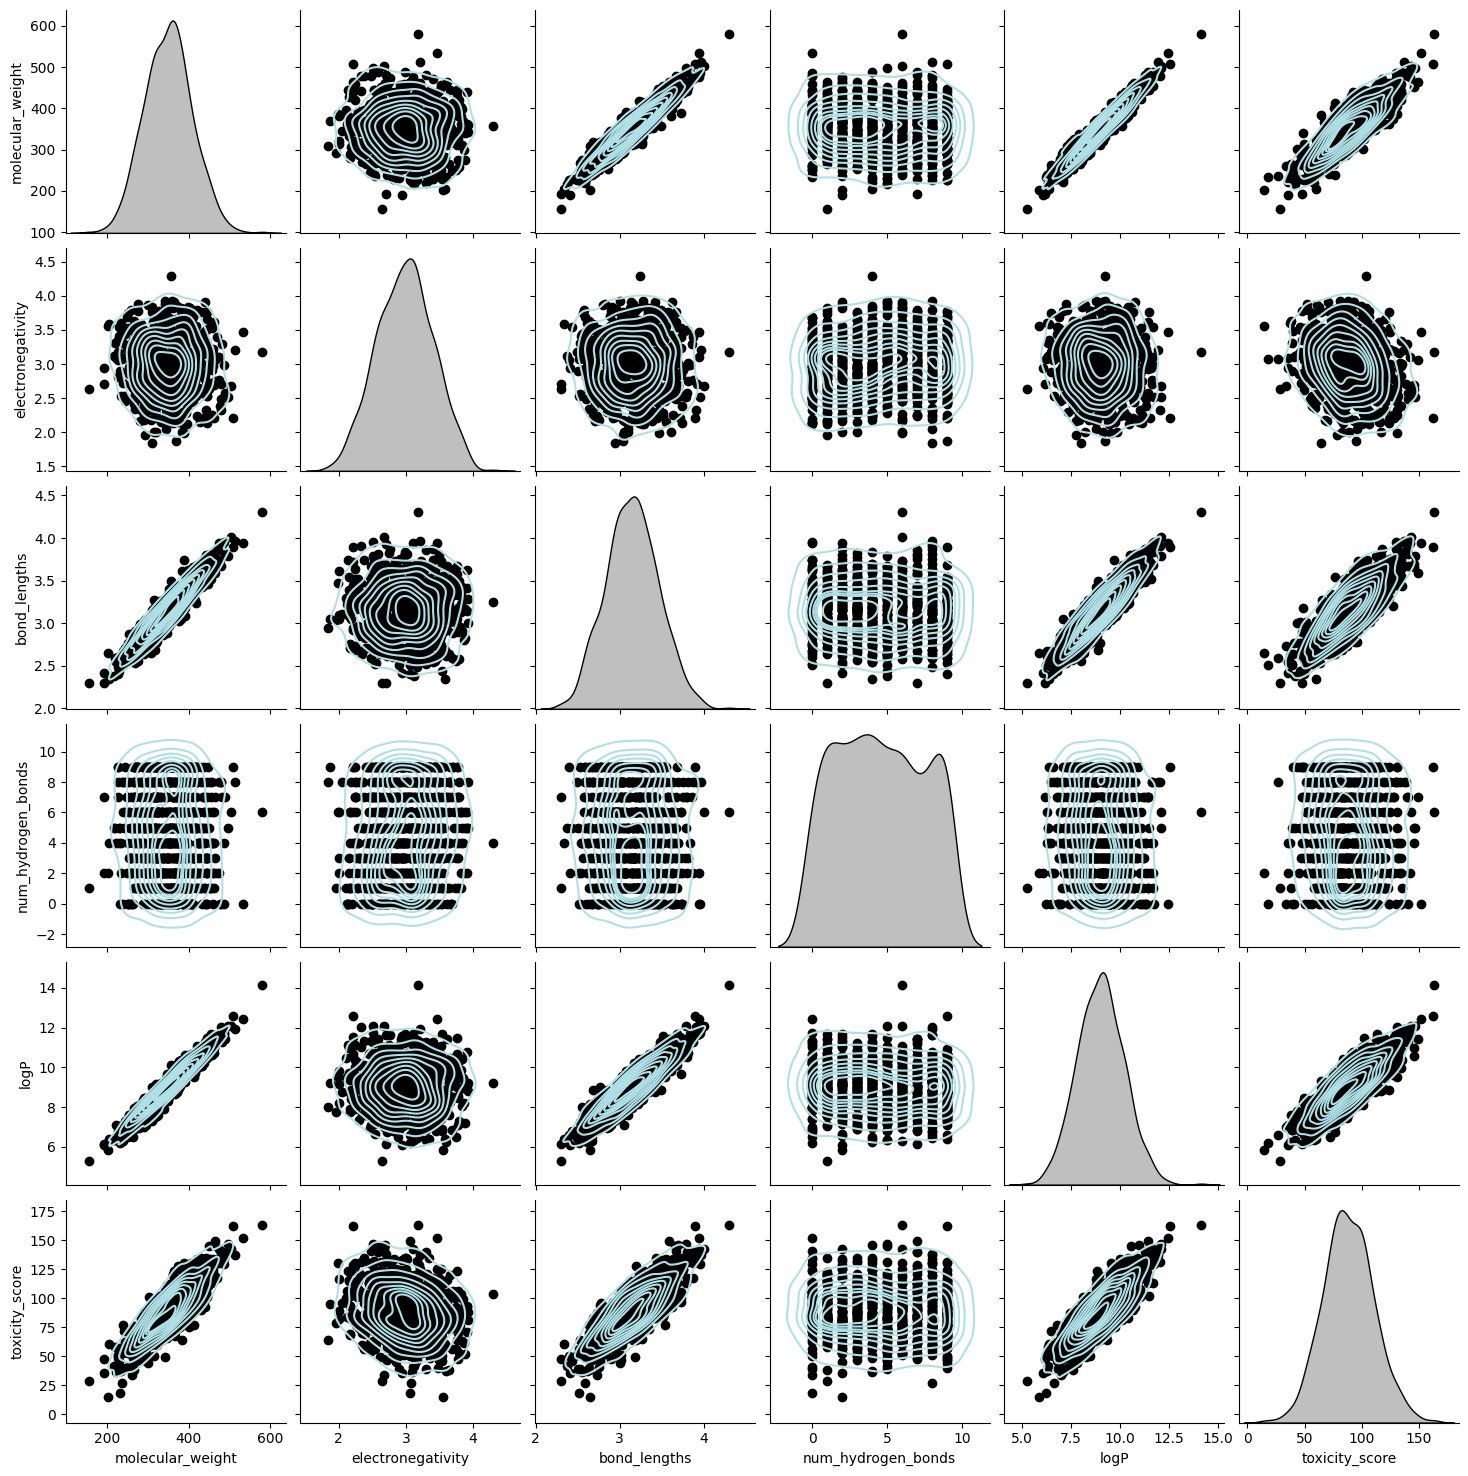

In [15]:
out = sns.pairplot(Train, kind="kde", \
                   plot_kws={'color':[176/255,224/255,230/255]}, \
                   diag_kws={'color':'black'})
out.map_offdiag(plt.scatter, color = 'black')
plt.show()

<br>

**3) Scaling the Data**<br>
<br>

In order to avoid that the model gets optimized for quantities that appear to have large values because of an arbritaryly choosen unit system, the data has to be normalized and scaled to the same dynamical range.

In [75]:
scaler    = MinMaxScaler(feature_range = (0, 1)) #mean  = 0 and std = 1
All       = pd.concat((Train, Test), axis = 0)
(rows, _) = Train.shape
AllS      = scaler.fit_transform(All)

#scaling returns an array, but we need a dataframe for the fit routine
TrainS = pd.DataFrame(AllS[:rows,:], columns = Train.columns)
TestS  = pd.DataFrame(AllS[rows:,:], columns = Train.columns)

<br>

**4) Performing the Fit**<br>
<br>

In [77]:
equation = 'toxicity_score ~ ' + '+'.join(Train.columns[:-1])
print(equation)

toxicity_score ~ molecular_weight+electronegativity+bond_lengths+num_hydrogen_bonds+logP


Where the toxicity score correponds to $y$ (dependent variable) and molecular weight, electronegativity, bond lengths, number of hydrogen bonds and logP correpond to the $x_n$ in<br>
<br>
$y = \beta_0 + \Sigma_{n = 1}^{N} \beta_n\,x_n + \epsilon$
<br>

Fitting the model using *OLS*:

In [79]:
#OLS (ordinary least squares)
my_model = ols(equation, data = TrainS).fit()
my_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         toxicity_score   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     597.5
Date:                Tue, 17 Sep 2024   Prob (F-statistic):          3.34e-266
Time:                        02:53:53   Log-Likelihood:                 1013.0
No. Observations:                 800   AIC:                            -2014.
Df Residuals:                     794   BIC:                            -1986.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1500      0.012     12.554      0.000       0.127       0.174
molecular_weight       0.7961      0.089      8.982      0.000       0.622       0.970
electronegativity     -0.1688      0.015    -11.591      0.000      -0.197      -0.140
bond_lengths           0.0204      0.049      0.417      0.677      -0.076       0.116
num_hydrogen_bonds     0.0035      0.008      0.458      0.647      -0.011       0.018
logP                   0.1246      0.072      1.723      0.085      -0.017       0.267
==============================================================================
Omnibus:                        2.249   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                2.240
Skew:                          -0.129   Prob(JB):                        0.326
Kurtosis:                       2.980   Cond. No.                         65.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The fit is significant, because the p-value Prob (F-statistic) for the constant model equals 3.34e-266, i.e. equals zero.<br>
The degree of freedom is more than an order of magintude larger than the number of regressors as it should be.<br>
Molecular weight, electronegativity and intercept are significant (p-values are below 0.01). However, these p-values are derived by comparing the fit residuals of the **complete model** to the fit residuals of the model without the single corresponding regressor using a t-test (see t-value in table above). This might lead to an underestimation of the influence of the regressor on the model, if the number of regressors is large.<br>  
Therefore, an **ANOVA** which compares the *N* fit residuals of the model without **each** of the *N* single regressors gives a better estimate of the p-values. 

In [81]:
table    = sm.stats.anova_lm(my_model, typ = 1)
print(table)

                       df     sum_sq    mean_sq            F         PR(>F)
molecular_weight      1.0  13.346285  13.346285  2847.525516  8.024085e-265
electronegativity     1.0   0.640388   0.640388   136.631363   3.085962e-29
bond_lengths          1.0   0.000684   0.000684     0.145954   7.025342e-01
num_hydrogen_bonds    1.0   0.000703   0.000703     0.150055   6.985866e-01
logP                  1.0   0.013917   0.013917     2.969353   8.524510e-02
Residual            794.0   3.721459   0.004687          NaN            NaN


<br>

**5) Evaluating the Fit**<br>
<br>

Using ANOVA or the t-test for calculating the p-values of the regressors requires the fit residuals to be approximatly normally distributed. Therefore, we create a histogram and a Q-Q plot of the fit resiudals. 

In [83]:
residuals = my_model.resid

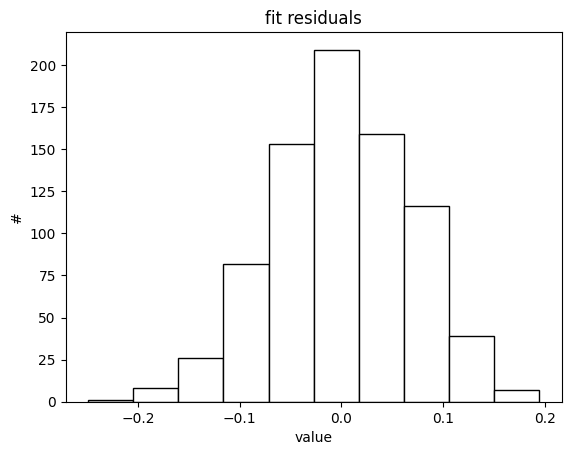

In [85]:
plt.hist(residuals, color = 'w', edgecolor = 'black')
plt.title('fit residuals')
plt.ylabel('#')
plt.xlabel('value')
plt.show()

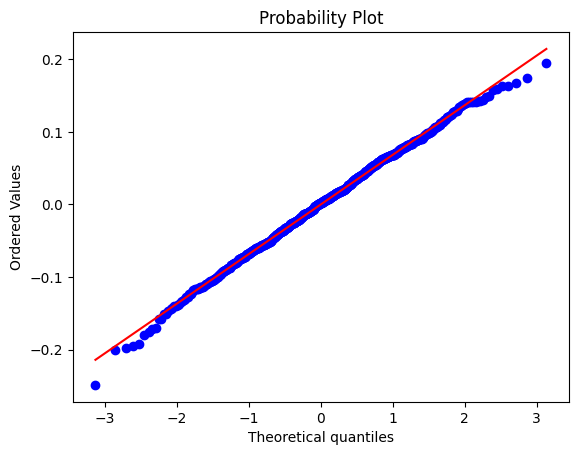

In [62]:
stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

It all looks great and the stats make sense. Thus we can apply the model now:

In [97]:
Ypred = my_model.predict(TestS)

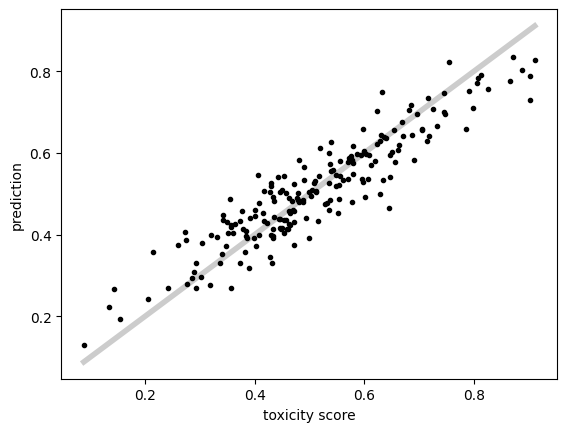

In [99]:
higher = np.max([Ypred, TestS.toxicity_score])
lower  = np.min([Ypred, TestS.toxicity_score])

plt.plot([lower, higher], [lower, higher], c = [0, 0, 0, 0.2], linewidth = 4)
plt.scatter(TestS.toxicity_score, Ypred, marker = '.', c = 'k')
plt.ylabel('prediction')
plt.xlabel('toxicity score')
plt.show()

Again, the plot looks great. There are no systematic deviations. Finally, let us calculate the mean deviation between prediction and actual value of the toxicity score:

In [101]:
mean_dev = np.sum(abs(TestS.toxicity_score - Ypred))/len(Ypred)
print(mean_dev)

0.04814407766310298


##### The result is 5%. A good fit